## Task B: Finegrained

We use the finegrained task  here



In [ ]:
%load_ext autoreload
%autoreload 2

from hatedetection import load_datasets
import glob
import json

train_dataset, dev_dataset, test_dataset = load_datasets(add_body=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Obs

`text` hace referencia al contexto del tweet del diario
`title` al título de la noticia (extraído del artículo)

In [14]:


evaluations = {
}
for model_name, path in [
    ('none', "../evaluations/beto_fine_none_weighted.json"), 
    ('text', "../evaluations/beto_fine_title.json"),   
    ('body', "../evaluations/beto_fine_body.json"),   
    ('none-ft', "../evaluations/betonews_fine_none.json"),   
    ('text-ft', "../evaluations/betonews_fine_text.json"),   
    ('body-ft', "../evaluations/betonews_fine_body.json"),   
    ]:

    with open(path) as f:
        evaluations[model_name] = json.load(f)

for key, evals in evaluations.items():
    print(f"We have {len(evals['metrics'])} {key} evaluations")


We have 10 none evaluations
We have 10 text evaluations
We have 10 body evaluations
We have 10 none-ft evaluations
We have 10 text-ft evaluations
We have 15 body-ft evaluations


In [15]:
import pandas as pd

metric_columns = [
    'calls_f1', 
    'women_f1', 'lgbti_f1', 'racism_f1',
    'class_f1', 'politics_f1', 'disabled_f1',
    'appearance_f1', 'criminal_f1', 'mean_f1',
    'mean_precision', 'mean_recall', 'hate_precision', 'hate_recall', 'hate_f1',
]


chars = [
    'women_f1', 'lgbti_f1', 'racism_f1',
    'class_f1', 'politics_f1', 'disabled_f1',
    'appearance_f1', 'criminal_f1', 
]



dfs = []
for model_name, model_results in evaluations.items():
    model_evaluations = model_results["metrics"]
    
    if not model_evaluations:
        continue
    
    df = pd.DataFrame(model_evaluations)

    df.columns = [x.split("_", 1)[1] if "_" in x else x for x in df.columns]

    without_dash = model_name.replace("_", " ")

    sub_df = df[metric_columns].copy()
    
    mean_df = pd.DataFrame({
            f"{without_dash}": sub_df[metric_columns].mean(), 
            f"{without_dash} std": sub_df[metric_columns].std()
        })
    dfs.append(mean_df)

result_df = pd.concat(dfs, axis=1)

result_df["diff adding text"] = result_df["text-ft"] - result_df["none-ft"] 
#result_df["diff adding body"] = result_df["title+body mean"] - result_df["title mean"] 

result_df.loc[:, ["none", "text", "body", "none-ft", "text-ft", "body-ft"]]

,none,text,body,none-ft,text-ft,body-ft
calls_f1,0.646049,0.637964,0.653219,0.650639,0.684652,0.679740
women_f1,0.373342,0.410703,0.380862,0.388651,0.420590,0.421291
lgbti_f1,0.350842,0.451337,0.427298,0.366127,0.482327,0.444805
racism_f1,0.635225,0.687877,0.690725,0.653023,0.720456,0.711054
class_f1,0.400650,0.491260,0.451180,0.432677,0.511453,0.475798
politics_f1,0.555069,0.579044,0.591276,0.611459,0.624763,0.647687
disabled_f1,0.550690,0.584904,0.557098,0.581650,0.608863,0.578024
appearance_f1,0.725874,0.741284,0.755168,0.741637,0.766254,0.757547
criminal_f1,0.512597,0.650342,0.654259,0.529015,0.699382,0.667641
mean_f1,0.527815,0.581635,0.573454,0.550542,0.613193,0.598176


In [16]:
def print_mean(row, context, ):
    mean = row[context]
    std = row[context + " std"]
    return f"${mean:.3f} \pm {std:.3f}$"

display_df = pd.DataFrame()

for context, model_name in [
    ("none-ft", "BERT No Context"),
    ("text-ft", "BERT Title"), 
    ]:
    display_df[model_name] = result_df.apply(lambda x: print_mean(x, context), axis=1)

display_df["+F1 adding title"] = result_df["diff adding text"].apply(lambda x: f"{'+' if x > 0 else '-'}{abs(x):.3f}")
#display_df["+F1 adding body"] = result_df["diff adding body"].apply(lambda x: f"{'+' if x > 0 else '-'}{abs(x):.3f}")


display_df["metrics"] = display_df.index.map(lambda x: " ".join([y.capitalize() for y in x.split("_")]))

display_df.reset_index(inplace=True)
del display_df["index"]
display_df.set_index("metrics", inplace=True)

#display_df = display_df.T[["Mean F1"]]
#display_df.sort_values("+F1 adding title", inplace=True)

display_df

characteristics = [
    'Calls F1', 
    'Women F1', 'Lgbti F1', 'Racism F1', 'Class F1',
    'Politics F1', 'Disabled F1', 'Appearance F1', 'Criminal F1', 
]
other = [
    'Mean F1', 'Mean Precision', 'Mean Recall', 'Hate Precision', 'Hate Recall', 'Hate F1'
]

sorted_characteristics = display_df.loc[characteristics].sort_values("+F1 adding title").index 


display_df.loc[
    list(sorted_characteristics) + other
]

,BERT No Context,BERT Title,+F1 adding title
metrics,,,
Politics F1,$0.611 \pm 0.008$,$0.625 \pm 0.013$,+0.013
Appearance F1,$0.742 \pm 0.010$,$0.766 \pm 0.009$,+0.025
Disabled F1,$0.582 \pm 0.013$,$0.609 \pm 0.018$,+0.027
Women F1,$0.389 \pm 0.015$,$0.421 \pm 0.017$,+0.032
Calls F1,$0.651 \pm 0.019$,$0.685 \pm 0.009$,+0.034
Racism F1,$0.653 \pm 0.010$,$0.720 \pm 0.004$,+0.067
Class F1,$0.433 \pm 0.013$,$0.511 \pm 0.020$,+0.079
Lgbti F1,$0.366 \pm 0.019$,$0.482 \pm 0.019$,+0.116
Criminal F1,$0.529 \pm 0.011$,$0.699 \pm 0.019$,+0.170


## Roc CURVES

In [17]:
import torch
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

data = []

auc_scores = {
    "none": [],
    "text": [],
}

cols = ['CALLS', 'WOMEN', 'LGBTI', 'RACISM', 'CLASS', 'POLITICS', 'DISABLED', 'APPEARANCE', 'CRIMINAL']

labels = torch.Tensor([test_dataset[col] for col in cols]).T

for context, evals in [
    ("none", evaluations["none-ft"]), 
    ("text", evaluations["text-ft"]),
    #("Hyphen", evaluations["hyphen"]),
    #("Title+Body", evaluations["title+body"])]:
]:
    for i, evaluation in enumerate(evals["predictions"]): 
        all_preds = torch.Tensor(evaluation)
        # Uso 2 porque es el índice de LGBTI
        lgbti_logits = all_preds[:, 2]
        y_score = torch.sigmoid(lgbti_logits)
        y_true = torch.Tensor(labels)[:, 2]
        fpr, tpr, _ = roc_curve(y_true, y_score)
        
        score = roc_auc_score(y_true, y_score)
        auc_scores[context].append(score)

        this_points = []

        x_interp = np.arange(0, 1, 5e-3)
        y_interp = np.interp(x_interp, xp=fpr, fp=tpr)
        for x, y in zip(x_interp, y_interp):
            this_points.append({
                "fpr": x,
                "tpr": y,
                "context": context,
                "i": i,  
            })

        data += this_points

auc_scores = {k: np.array(v) for k, v in auc_scores.items()}

#plt.plot(fpr, tpr, color='darkorange',  lw=2)


#fpr, tpr, _ = roc_curve(y_true, y_score)

#plt.plot(fpr, tpr, color='blue', lw=2)

df = pd.DataFrame(data)

auc_scores
#

{'none': array([0.8614299 , 0.85550403, 0.87646077, 0.87675149, 0.86252197,
        0.86899708, 0.86242444, 0.85034823, 0.86367705, 0.86928689]),
 'text': array([0.93748424, 0.93813194, 0.94992548, 0.95138716, 0.93892178,
        0.94275137, 0.94198775, 0.94929319, 0.93490082, 0.93603981])}

## Plot

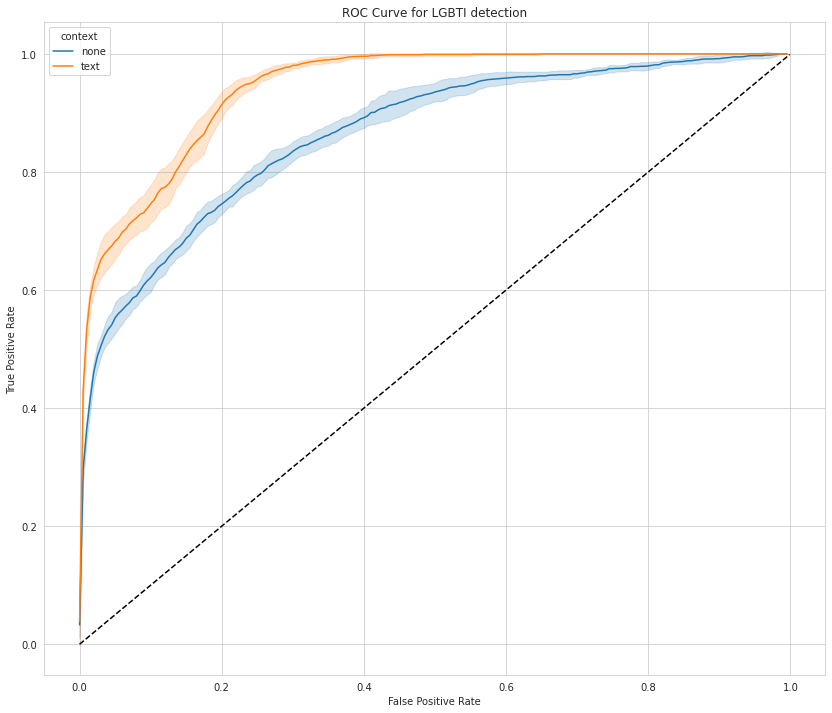

In [18]:

sns.set_style("whitegrid")
#p = df[(df["context"] == "none") & (df["i"] <= 1)]
g = sns.lineplot(data=df, x="fpr", y="tpr", hue="context", ci="sd")
# Random 
plt.plot(np.arange(0, 1, 1e-3), np.arange(0, 1, 1e-3), "k--")

plt.title("ROC Curve for LGBTI detection")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
g.figure.set_figwidth(14)
g.figure.set_figheight(12)


## Bar plots

In [19]:
metrics = [
    'calls_f1', 'women_f1', 'lgbti_f1', 'racism_f1',
    'class_f1', 'politics_f1', 'disabled_f1',
    'appearance_f1', 'criminal_f1'
]


dfs = []

for context in ["none-ft", "text-ft", "body-ft"]:
    df = pd.DataFrame(evaluations[context]["metrics"])
    df.columns = [x.split("_", 1)[1] for x in df.columns]
    df = df.loc[:, metrics].copy()
    df["context"] = context
    dfs.append(df)

df = pd.concat(dfs)

df

,calls_f1,women_f1,lgbti_f1,racism_f1,class_f1,politics_f1,disabled_f1,appearance_f1,criminal_f1,context
0,0.656430,0.371981,0.372414,0.640657,0.432432,0.617234,0.577406,0.733509,0.527822,none-ft
1,0.655367,0.372315,0.353741,0.662352,0.410256,0.620038,0.585938,0.753741,0.526799,none-ft
2,0.667925,0.397260,0.394649,0.667366,0.461538,0.616302,0.578313,0.733850,0.528244,none-ft
3,0.610895,0.400000,0.344086,0.651564,0.425993,0.614786,0.579592,0.742323,0.522314,none-ft
4,0.656189,0.396181,0.371622,0.647465,0.442748,0.597980,0.586345,0.752066,0.547771,none-ft
5,0.642715,0.377358,0.359862,0.656144,0.428571,0.604462,0.593496,0.755556,0.530744,none-ft
6,0.665399,0.369021,0.394737,0.646872,0.431227,0.610229,0.570342,0.725828,0.525191,none-ft
7,0.657588,0.385882,0.336996,0.638604,0.437956,0.599222,0.574713,0.732620,0.544283,none-ft
8,0.666667,0.405797,0.358974,0.663765,0.432836,0.614458,0.560976,0.738889,0.528620,none-ft
9,0.627219,0.410714,0.374194,0.655446,0.423208,0.619883,0.609375,0.747989,0.508361,none-ft


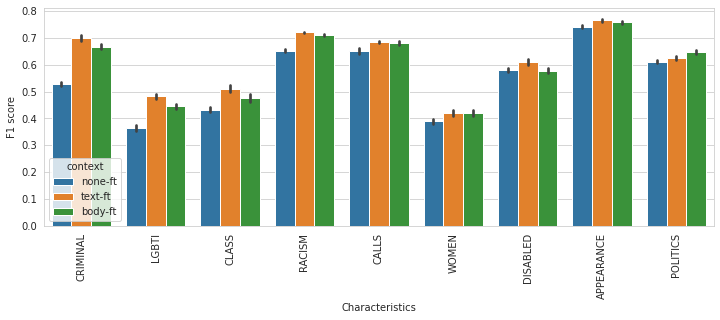

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
data = df.melt(id_vars=["context"], value_vars=metrics)

def process_key(x):
    return x.split("_")[0].upper()

"""
Calculo el orden de las características en base a los que más impacta el contexto

"""
hue_order = [process_key(k) for k in (result_df["text-ft"] - result_df["none-ft"])[metrics].sort_values(ascending=False).keys()]

data["variable"] = data["variable"].apply(process_key)

data = data.sort_values("value")

plt.figure(figsize=(12, 4))
sns.barplot(data=data, x="variable", y="value", hue="context", order=hue_order)

plt.xticks(rotation=90)
plt.ylabel("F1 score")
plt.xlabel("Characteristics")


plt.savefig("imgs/task_b_scores.pdf", bbox_inches="tight")

In [21]:
metrics = [
    'calls_f1', 'women_f1', 'lgbti_f1', 'racism_f1',
    'class_f1', 'politics_f1', 'disabled_f1',
    'appearance_f1', 'criminal_f1'
]


dfs = []

for context in ["none-ft", "text-ft", "body-ft"]:
    df = pd.DataFrame(evaluations[context]["metrics"])
    df.columns = [x.split("_", 1)[1] for x in df.columns]
    df["context"] = context
    dfs.append(df)

df = pd.concat(dfs)

df.columns

Index(['loss', 'calls_f1', 'women_f1', 'lgbti_f1', 'racism_f1', 'class_f1',
       'politics_f1', 'disabled_f1', 'appearance_f1', 'criminal_f1', 'mean_f1',
       'mean_precision', 'mean_recall', 'hate_precision', 'hate_recall',
       'hate_f1', 'runtime', 'samples_per_second', 'steps_per_second',
       'context'],
      dtype='object')

In [22]:
import scipy.stats

scipy.stats.mannwhitneyu(df[df["context"] == "none-ft"]["mean_f1"], df[df["context"] == "text-ft"]["mean_f1"])

MannwhitneyuResult(statistic=0.0, pvalue=9.133589555477501e-05)

In [34]:
from hatedetection import extended_hate_categories

pvals = []

for characteristic in extended_hate_categories:
    print(characteristic)
    char_name = f"{characteristic.lower()}_f1"

    pvals.append(
        scipy.stats.mannwhitneyu(df[df["context"] == "none-ft"][char_name], df[df["context"] == "text-ft"][char_name], alternative="less")
    )
    


CALLS
WOMEN
LGBTI
RACISM
CLASS
POLITICS
DISABLED
APPEARANCE
CRIMINAL


In [35]:
pvals

[MannwhitneyuResult(statistic=0.0, pvalue=9.133589555477501e-05),
 MannwhitneyuResult(statistic=7.0, pvalue=0.0006574723348566069),
 MannwhitneyuResult(statistic=0.0, pvalue=9.133589555477501e-05),
 MannwhitneyuResult(statistic=0.0, pvalue=9.133589555477501e-05),
 MannwhitneyuResult(statistic=0.0, pvalue=9.082557304573249e-05),
 MannwhitneyuResult(statistic=13.5, pvalue=0.003240797585854522),
 MannwhitneyuResult(statistic=12.0, pvalue=0.002277926902929603),
 MannwhitneyuResult(statistic=3.0, pvalue=0.00021981937631328227),
 MannwhitneyuResult(statistic=0.0, pvalue=9.133589555477501e-05)]

In [37]:
from statsmodels.stats.multitest import multipletests

multipletests([x.pvalue for x in pvals], alpha=0.05, method="bonferroni")

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True]),
 array([0.00082202, 0.00591725, 0.00082202, 0.00082202, 0.00081743,
        0.02916718, 0.02050134, 0.00197837, 0.00082202]),
 0.005683044988048058,
 0.005555555555555556)